In [1]:
import subprocess
import os

import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
from roms_regrid import *
from celluloid import Camera 
import cartopy.crs as ccrs
import seawater as sw

/tmp/ipykernel_1041112/1143814594.py:15: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
grid=xr.open_dataset('/global/cfs/cdirs/m4632/uheede/work/Iceland4_BGC/INPUT/Iceland4_grd.nc')
grid_pr=grid
h=grid['h'].values
mask_rho=grid['mask_rho'].values
pm=grid['pm'].values
pn=grid['pn'].values

In [ ]:
grid['h']

In [3]:
x1=xr.open_mfdataset('/pscratch/sd/u/uheede/Iceland4_noBGC_pip_pt_FLOW/Iceland4_noBGC_FLOW_rnd.201206[2-3][1-9]??0000.nc', combine='nested', concat_dim=["time"])
#x2=xr.open_mfdataset('/pscratch/sd/u/uheede/Iceland4_noBGC_pip_pt_ens1/Iceland4_noBGC_ens1_rnd.201206*.nc', combine='nested', concat_dim=["time"])
#x3=xr.open_mfdataset('/pscratch/sd/u/uheede/Iceland4_noBGC_pip_pt_ens2/Iceland4_noBGC_ens2_rnd.2012062[1-6]*.nc', combine='nested', concat_dim=["time"])



In [4]:
mask_regrid=roms_regrid(grid,grid['mask_rho'])


In [5]:
## calculating depth of each cell
mask_rho=grid['mask_rho'].values
h=grid['h'].values
# Sigma coordinate parameters
N = 100
theta_s = 5
theta_b = 2
hc = 300

k_w = np.linspace(0,N,N+1)
k_r = np.linspace(1,N,N)

sigma_w = (k_w - N) / N
sigma_r = (k_r - N - 0.5) / N

# Assuming that theta_s and theta_b are both > 0
# https://www.myroms.org/wiki/Vertical_S-coordinate

def Cs(sigma, theta_s, theta_b):
    C = ( 1 - np.cosh(theta_s * sigma) ) / (np.cosh(theta_s) - 1)
    C = (np.exp(theta_b * C) - 1) / (1 - np.exp(-theta_b))
    return C

Cs_w = Cs(sigma_w, theta_s, theta_b)
Cs_r = Cs(sigma_r, theta_s, theta_b)

S_w = np.zeros((N+1, h.shape[0], h.shape[1]))
S_r = np.zeros((N, h.shape[0], h.shape[1]))
for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        if mask_rho[i,j]:
            S_w[:,i,j] = (hc * sigma_w + h[i,j]*Cs_w) / (hc + h[i,j])
            S_r[:,i,j] = (hc * sigma_r + h[i,j]*Cs_r) / (hc + h[i,j])

# zeta is the sea surface height at any given time, here I am using an arbitrary zeta

zeta1=x1['zeta'].isel(time=95).load().values

z_w1 = np.zeros((N+1, h.shape[0], h.shape[1]))
z_r1 = np.zeros((N, h.shape[0], h.shape[1]))

#zeta2=x2['zeta'].isel(time=48).load().values

#z_w2 = np.zeros((N+1, h.shape[0], h.shape[1]))
#z_r2 = np.zeros((N, h.shape[0], h.shape[1]))

#zeta3=x3['zeta'].isel(time=48).load().values

#z_w3 = np.zeros((N+1, h.shape[0], h.shape[1]))
#z_r3 = np.zeros((N, h.shape[0], h.shape[1]))

for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        if mask_rho[i,j]:
            z_w1[:,i,j] = zeta1[i,j] + (zeta1[i,j] + h[i,j])*S_w[:,i,j]
            z_r1[:,i,j] = zeta1[i,j] + (zeta1[i,j] + h[i,j])*S_r[:,i,j]
            #z_w2[:,i,j] = zeta2[i,j] + (zeta2[i,j] + h[i,j])*S_w[:,i,j]
            #z_r2[:,i,j] = zeta2[i,j] + (zeta2[i,j] + h[i,j])*S_r[:,i,j]
            #z_w3[:,i,j] = zeta3[i,j] + (zeta3[i,j] + h[i,j])*S_w[:,i,j]
            #z_r3[:,i,j] = zeta3[i,j] + (zeta3[i,j] + h[i,j])*S_r[:,i,j]
cell_depths1 = np.zeros((N, h.shape[0], h.shape[1]))
#cell_depths2 = np.zeros((N, h.shape[0], h.shape[1]))
#cell_depths3 = np.zeros((N, h.shape[0], h.shape[1]))


for k in np.arange(1,101):
    cell_depths1[k-1,:,:]=z_w1[k,:,:]-z_w1[k-1,:,:]
    #cell_depths2[k-1,:,:]=z_w2[k,:,:]-z_w2[k-1,:,:]
    #cell_depths3[k-1,:,:]=z_w3[k,:,:]-z_w3[k-1,:,:]
    

In [6]:
dye1_3d=x1['dye'].isel(time=95).load()


mass1=dye1_3d*1/pn*1/pm*cell_depths1
#mass2=dye2_3d*1/pn*1/pm*cell_depths2
#mass3=dye3_3d*1/pn*1/pm*cell_depths3

total1=np.sum(mass1.load()) #m3
#total2=np.sum(mass2.load()) #m3
#total3=np.sum(mass3.load()) #m3

NaOH_test1=9.975*10**3*1000*20 #(mol/L)*1000 (mmol/mol)*1000(L/IBC)*20(IBC)=mmol
NaOH_test2=9.975*10**3*1000*10
NaOH_test3=9.975*10**3*1000*5
NaOH_test4=9.975*10**3*1000*30

alk1_scalar1=NaOH_test1*(1/total1) #mmol/m3
alk1_scalar2=NaOH_test2*(1/total1)
alk1_scalar3=NaOH_test3*(1/total1)
alk1_scalar4=NaOH_test4*(1/total1)

#alk2_scalar1=NaOH_test1*(1/total2) #mmol/m3
#alk2_scalar2=NaOH_test2*(1/total2)
#alk2_scalar3=NaOH_test3*(1/total2)
#alk2_scalar4=NaOH_test4*(1/total2)

#alk3_scalar1=NaOH_test1*(1/total3) #mmol/m3
#alk3_scalar2=NaOH_test2*(1/total3)
#alk3_scalar3=NaOH_test3*(1/total3)
#alk3_scalar4=NaOH_test4*(1/total3)

In [7]:
dye1_alk1=x1['dye']*alk1_scalar1
dye1_alk2=x1['dye']*alk1_scalar2
dye1_alk3=x1['dye']*alk1_scalar3
dye1_alk4=x1['dye']*alk1_scalar4


In [8]:
dye_alk_surf=dye1_alk4.isel(s_rho=99)
dye1_alk4_rg=roms_regrid(grid,dye_alk_surf)

/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/xarray/core/computation.py:307: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 30.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (145, 289).
  result_var = func(*data_vars)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/array/routines.py:332: PerformanceWarning: Increasing number of chunks by factor of 30
  intermediate = blockwise(


In [9]:
dye1_alk4_rg.load()

<xarray.DataArray (time: 168, lat: 1442, lon: 722)> Size: 1GB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * lon      (lon) float64 6kB 337.7 337.7 337.7 337.7 ... 338.7 338.7 338.7
  * lat      (lat) float64 12kB 64.22 64.22 64.22 64.22 ... 64.42 64.42 64.42
Dimensions without coordinates: time
Attributes:
    regrid_method:  bilinear

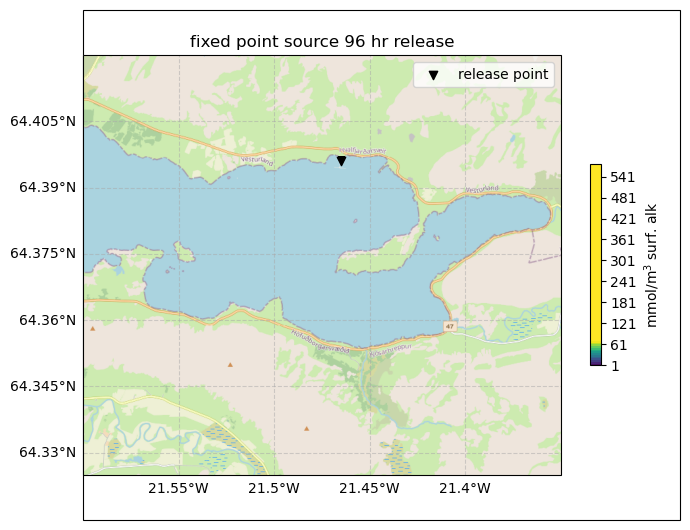

In [25]:
import cartopy.io.img_tiles as cimgt

request = cimgt.OSM()
extent = [-21.6, -21.35, 64.325, 64.42]

from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(7,7),subplot_kw={'projection': ccrs.Mercator()},layout='tight')
camera = Camera(fig)
ax = plt.axes(projection=request.crs)
ax.set_extent(extent)

ax.add_image(request, 12)
k1=1
k2=580
k3=5
levels=np.arange(k1, k2, k3)
   

levels2=np.arange(0, 10, 1)

for i in range(167):
    
    ax.text(0.8, 0.999, 't='+str(i+1)+' hours', transform=ax.transAxes)

    cf2=plt.contourf(dye1_alk4_rg.lon,dye1_alk4_rg.lat,mask_regrid.where(mask_regrid!=0),levels2, cmap='Greys', transform=ccrs.PlateCarree())
    
    cf1=plt.contourf(dye1_alk4_rg.lon,dye1_alk4_rg.lat,dye1_alk4_rg[i,:,:],levels, vmin=1, vmax=70,transform=ccrs.PlateCarree())

    
    camera.snap()

    plt.title('fixed point source 96 hr release')
    
ax.scatter(-21.465, 64.396, color="black", marker="v", transform=ccrs.PlateCarree(),label= "release point")
gls=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    color='darkgray', alpha=0.5, linestyle='--')
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels

ax.set_extent([-21.6, -21.35, 64.325, 64.42], ccrs.PlateCarree())
ax.legend()
cb1 = plt.colorbar(cf1,shrink=0.3)
cb1.set_label('mmol/m$^3$ surf. alk', fontsize=10)

animation = camera.animate()
HTML(animation.to_html5_video())

In [27]:
animation.save("96_hr_30IBC_withmap.mp4")

In [22]:
dye1_alk4_rg.shape

(168, 1442, 722)